<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_withFeatures_byGini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

> This colab is used to apply LSTM using the features selected from colab: CA_FeatureRanking_Gini.ipynb
> The features are selected by gini score using 3 different techniques


# Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [8]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CombinedData_Labeled_CDCGuideline_Jan15.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_MarylandData_Labeled_CDCGuideline_Jan15.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CombinedData_Labeled_CDCGuideline_Jan15.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_MarylandData_Labeled_CDCGuideline_Jan15.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.cs

In [9]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


# Combined data for CA

## Load combined data

In [10]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_alldatasets_Jan13.csv',low_memory=False)
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000


In [11]:
X_cols = [ 'mask_rule_active','m50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline','Date']

In [12]:
LA_combined_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols]
print(LA_combined_data.shape)
LA_combined_data.head(5)

(300, 10)


,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date
4940,0,3.9960,60,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,2020-03-01
4941,0,6.5020,98,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,2020-03-02
4942,0,6.5910,99,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,2020-03-03
4943,0,6.5950,100,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,2020-03-04
4944,0,7.0080,106,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,2020-03-05


In [13]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [14]:
len(LA_combined_data.columns)

10

In [15]:
LA_combined_data['Date'] = LA_combined_data['Date'].apply(lambda x: parse(x))
#LA_combined_data.index.name = 'Date'
LA_combined_data.head()

,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date
4940,0,3.9960,60,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,2020-03-01
4941,0,6.5020,98,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,2020-03-02
4942,0,6.5910,99,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,2020-03-03
4943,0,6.5950,100,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,2020-03-04
4944,0,7.0080,106,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,2020-03-05


## Preprocessing data for LSTM

In [16]:
LA_combined_data_selected = LA_combined_data[X_cols]

In [17]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
values = LA_combined_data.values
values[:,9]

array([Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-02 00:00:00'),
       Timestamp('2020-03-03 00:00:00'), Timestamp('2020-03-04 00:00:00'),
       Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'),
       Timestamp('2020-03-07 00:00:00'), Timestamp('2020-03-08 00:00:00'),
       Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'),
       Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'),
       Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-14 00:00:00'),
       Timestamp('2020-03-15 00:00:00'), Timestamp('2020-03-16 00:00:00'),
       Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'),
       Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'),
       Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'),
       Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'),
       Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'),
       Timestamp('2020-03

In [19]:
values = LA_combined_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,9] = encoder.fit_transform(values[:,9])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t)  var9(t)  var10(t)
1     0.0000     0.5419     0.5405  ...   1.0000   0.0000    0.0033
2     0.0000     0.8841     0.8829  ...   0.9885   0.0000    0.0067
3     0.0000     0.8962     0.8919  ...   0.9770   0.0303    0.0100
4     0.0000     0.8968     0.9009  ...   0.9770   0.0303    0.0134
5     0.0000     0.9532     0.9550  ...   0.9770   0.0303    0.0167

[5 rows x 20 columns]


## Train Test Split

In [20]:
values.shape[0]

300

In [21]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

236
values shape  (299, 20)
(236, 1, 19) (236,) (63, 1, 19) (63,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.4421 - val_loss: 0.9183
Epoch 2/100
4/4 - 0s - loss: 0.3602 - val_loss: 0.8228
Epoch 3/100
4/4 - 0s - loss: 0.2915 - val_loss: 0.7279
Epoch 4/100
4/4 - 0s - loss: 0.2295 - val_loss: 0.6342
Epoch 5/100
4/4 - 0s - loss: 0.1797 - val_loss: 0.5470
Epoch 6/100
4/4 - 0s - loss: 0.1548 - val_loss: 0.4719
Epoch 7/100
4/4 - 0s - loss: 0.1500 - val_loss: 0.4113
Epoch 8/100
4/4 - 0s - loss: 0.1547 - val_loss: 0.3670
Epoch 9/100
4/4 - 0s - loss: 0.1620 - val_loss: 0.3379
Epoch 10/100
4/4 - 0s - loss: 0.1668 - val_loss: 0.3229
Epoch 11/100
4/4 - 0s - loss: 0.1666 - val_loss: 0.3191
Epoch 12/100
4/4 - 0s - loss: 0.1618 - val_loss: 0.3226
Epoch 13/100
4/4 - 0s - loss: 0.1541 - val_loss: 0.3306
Epoch 14/100
4/4 - 0s - loss: 0.1449 - val_loss: 0.3397
Epoch 15/100
4/4 - 0s - loss: 0.1360 - val_loss: 0.3467
Epoch 16/100
4/4 - 0s - loss: 0.1280 - val_loss: 0.3506
Epoch 17/100
4/4 - 0s - loss: 0.1208 - val_loss: 0.3518
Epoch 18/100
4/4 - 0s - loss: 0.1144 - val_loss: 0.3503
E

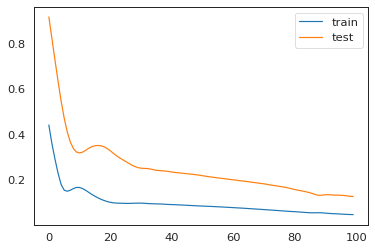

In [22]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [23]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(63, 19)
Test MSE: 0.020
Test RMSE: 0.140


In [24]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

median_absolute_error 0.12078458
mean_absolute_error 0.1267661


# Maryland inertia Data for CA

## Load Maryland Data

In [36]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_processedMarylandData_Jan11.csv',low_memory=False)
maryland_sd_inertia.head(5)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,0,1666753,-21.7000,2020-01-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,0,1666753,-5.8000,2020-01-02,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,0,1666753,-1.5000,2020-01-03,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,0,1666753,-2.2000,2020-01-04,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,0,1666753,-12.1000,2020-01-05,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,0.0000


In [37]:
maryland_sd_inertia.head()

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,0,1666753,-21.7000,2020-01-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,0,1666753,-5.8000,2020-01-02,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,0,1666753,-1.5000,2020-01-03,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,0,1666753,-2.2000,2020-01-04,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,0,1666753,-12.1000,2020-01-05,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,0.0000


In [38]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [39]:
inertia_X_cols = ['Social.distancing.index', 'X..staying.home', 'Trips.person',
                  'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
                  'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases','X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans','X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home',
       'Cumulative.inflation.rate', 'date']

In [55]:
County_inertia_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols]
print(len(County_inertia_data.columns))
County_inertia_data.head()

38


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,date
6534,49,32,2.4200,12.1000,0.6000,31.4000,0.2100,2.2100,0,-20.1000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-01
6535,22,21,3.1900,11.3000,0.5000,36.6000,0.5600,2.6200,0,-5.3000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-02
6536,18,20,3.3200,11.2000,0.4000,37.9000,0.5600,2.7700,0,0.2000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-03
6537,29,24,3.1000,11.6000,0.5000,36.0000,0.3000,2.7900,0,0.9000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,2020-01-04
6538,40,28,2.7500,11.3000,0.5000,33.1000,0.2500,2.5000,0,-9.6000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,140,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,2020-01-05


## Preprocess Data

In [52]:
#County_inertia_data = County_inertia_data.dropna()

In [56]:
col_idx = County_inertia_data.columns.get_loc("date")
print(col_idx)

37


In [57]:
values = County_inertia_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

Empty DataFrame
Columns: [var1(t-1), var2(t-1), var3(t-1), var4(t-1), var5(t-1), var6(t-1), var7(t-1), var8(t-1), var9(t-1), var10(t-1), var11(t-1), var12(t-1), var13(t-1), var14(t-1), var15(t-1), var16(t-1), var17(t-1), var18(t-1), var19(t-1), var20(t-1), var21(t-1), var22(t-1), var23(t-1), var24(t-1), var25(t-1), var26(t-1), var27(t-1), var28(t-1), var29(t-1), var30(t-1), var31(t-1), var32(t-1), var33(t-1), var34(t-1), var35(t-1), var36(t-1), var37(t-1), var38(t-1), var1(t), var2(t), var3(t), var4(t), var5(t), var6(t), var7(t), var8(t), var9(t), var10(t), var11(t), var12(t), var13(t), var14(t), var15(t), var16(t), var17(t), var18(t), var19(t), var20(t), var21(t), var22(t), var23(t), var24(t), var25(t), var26(t), var27(t), var28(t), var29(t), var30(t), var31(t), var32(t), var33(t), var34(t), var35(t), var36(t), var37(t), var38(t)]
Index: []


## Train Test split

In [58]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

0
values shape  (0, 76)
(0, 1, 75) (0,) (0, 1, 75) (0,)


## Training LSTM for inertia data

In [59]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/100


ValueError: ignored

## Testing LSTM for inertia data

In [60]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

In [ ]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))